<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_5_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Recurrent Neural Networks

In [ ]:
%tensorflow_version 1.x
!pip install livelossplot
!pip install keras==2.2.5
!pip install keras==2.2.5
from keras.callbacks import LambdaCallback
from keras import Input, Model
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import get_file
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import numpy as np
import sys
import re
from collections import Counter
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 8.3MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3f200dc2-5bc4-e03f-935f-b9933378349c)


In [ ]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [ ]:
path = get_file('trump.txt', origin='https://raw.githubusercontent.com/ryanmcdermott/trump-speeches/master/speeches.txt')

with open(path, encoding='utf-8') as f:
    text = f.read()
    
print(Counter(text))
text = text.lower()
text = re.sub('\n+','\n',text)
text = re.sub(r'[^a-z0-9 \n.,\'"?!$%-]','',text)
print('corpus length:', len(text))

925696/924745 [==============================] - 0s 0us/step
Counter({' ': 164220, 'e': 79150, 't': 60637, 'o': 54015, 'a': 49780, 'n': 45386, 'i': 39450, 's': 33723, 'h': 32820, 'r': 32820, 'l': 26017, 'd': 23285, 'u': 19134, 'y': 17173, 'g': 16934, '.': 15959, 'w': 14991, 'm': 14530, 'c': 12868, 'p': 11379, 'b': 10743, 'I': 9830, 'f': 9066, ',': 8770, '’': 8443, 'v': 8375, '\n': 7677, 'k': 7002, 'T': 5917, 'A': 5240, 'E': 4270, 'O': 3477, 'S': 3417, 'W': 3312, 'N': 2963, 'H': 2596, 'R': 2125, 'B': 2050, 'Y': 1845, 'C': 1599, 'L': 1594, '"': 1574, 'D': 1531, 'M': 1384, '?': 1303, '–': 1301, 'G': 1202, 'P': 1128, 'U': 1110, '0': 1097, 'j': 932, "'": 918, 'x': 773, 'F': 760, '1': 581, 'K': 526, '—': 515, '-': 506, 'V': 482, 'z': 457, '5': 409, '2': 404, '$': 385, 'J': 367, 'q': 288, '%': 271, '4': 201, '3': 183, '6': 142, ';': 133, '9': 114, '…': 101, '7': 91, '8': 85, '!': 65, ':': 58, '[': 50, ']': 50, '(': 39, ')': 39, 'Q': 25, 'X': 24, 'Z': 24, '‘': 19, '/': 12, '“': 9, '”': 9, '_':

In [ ]:
chars = sorted(set(text))
print('vocab size:', len(chars))
char_indices = {c:i for i, c in enumerate(chars)}
indices_char = {i:c for i, c in enumerate(chars)}

vocab size: 47


In [ ]:
# cut the text in semi-redundant sequences of max_seq_len characters
max_seq_len = 40
step = 3

def get_seq(data):
    sentences = []
    next_chars = []
    for i in range(0, len(data) - max_seq_len, step):
        sentences.append(data[i: i + max_seq_len])
        next_chars.append(data[i + max_seq_len])
    
    # vectorize:
    x = np.zeros((len(sentences), max_seq_len, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    
    return x,y

In [ ]:
split_idx = int(len(text)*0.9)
train = text[:split_idx]
valid = text[split_idx:]

x,y = get_seq(train)
print('number of sequences in train:', len(x))
x_val,y_val = get_seq(valid)
print('number of sequences in validation:', len(x_val))

number of sequences in train: 264614
number of sequences in validation: 29390


In [ ]:
# build the model
def get_model(max_seq_len, vocab_size, nodes, depth=1):
    inputs = Input(shape=(max_seq_len, vocab_size))
    f = inputs
    for i in range(depth):
        f = LSTM(nodes, dropout=0.2, recurrent_dropout=0.2, return_sequences=i<depth-1)(f)
    f = Dropout(0.2)(f)
    outputs = Dense(vocab_size, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
#temperature = 0
#temperature = 1
temperature = 0.5

def get_next_char(preds):
     # these are necessary due to numerical precision issues:
    preds = np.asarray(preds, dtype=np.float64)
    preds = preds / np.sum(preds)
    
    # your code here:
    if temperature == 0:
        probas = preds
    elif temperature == 1:
        probas = np.random.multinomial(1, preds)
    else:
        # helper function to sample an index from a probability array
        exp_preds = np.exp(np.log(preds+1e-6) / temperature)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds)
    next_index = np.argmax(probas)
    return indices_char[next_index]

In [ ]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    if epoch%10 != 0:
        return
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    data = valid
    
    start_index = np.random.randint(0, len(data) - max_seq_len - 1)
        
    sentence = data[start_index: start_index + max_seq_len]
    generated = sentence
    print('----- Generating with seed: "' + sentence + '"')
    print()
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, max_seq_len, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_char = get_next_char(preds)

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
optimizer = RMSprop(lr=0.01)
batch_size = 128
epochs = 21

In [ ]:
model = get_model(max_seq_len, len(chars), 128, depth=1)
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

seed(42)
set_random_seed(43)

history = model.fit(x, y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[print_callback], validation_data=(x_val,y_val))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 47)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               90112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 47)                6063      
Total params: 96,175
Trainable params: 96,175
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 264614 samples, valid

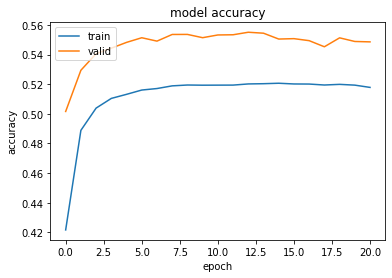

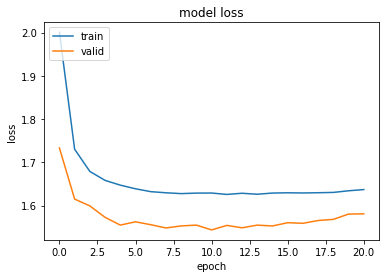

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model = get_model(max_seq_len, len(chars), 64, depth=2)
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

seed(42)
set_random_seed(43)

history = model.fit(x, y,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[print_callback], validation_data=(x_val,y_val))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 47)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 64)            28672     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 47)                3055      
Total params: 64,751
Trainable params: 64,751
Non-trainable params: 0
_________________________________________________________________
None
Train on 264614 samples, validate on 29390 samples
Epoch 1/21
264614/264614 [==============================] - 273s 

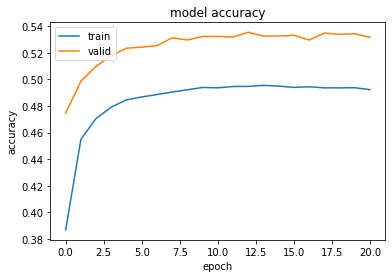

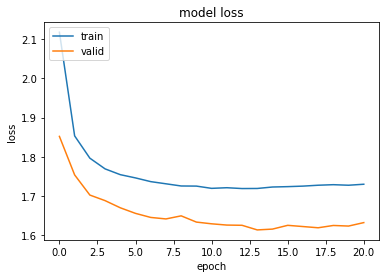

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()